### Helper

In [1]:
import os
import sys

# to import functions from `patching_utils.py` and `plotly_utils.py`,
# we need to add the repository directory to the system path.
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
if current_dir not in sys.path:
    sys.path.append(current_dir)

/home/qinyuan/function-induction


In [2]:
import torch as t
from torch import Tensor
import torch.nn.functional as F

from transformer_lens import HookedTransformer, patching, ActivationCache, utils
from transformer_lens.hook_points import HookPoint

t.set_grad_enabled(False)

from jaxtyping import Float, Int, Bool
from typing import Literal, Callable, Dict, Tuple
from functools import partial

from IPython.display import display, HTML
from plotly_utils import imshow, line, scatter, bar
from patching_utils import prepare_data_for_fwd

from tqdm import trange

/home/qinyuan/miniconda3/envs/fi4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda:9"
model_name = "google/gemma-2-9b"

model = HookedTransformer.from_pretrained(model_name, device=device)
model.set_ungroup_grouped_query_attention(True)

Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00, 137.44it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [4]:
from data_utils import process_dataset, read_jsonl

def load_data(offset):
    setting, nmax, offset, n_icl_examples = "setting1", 9, offset, 4
    filename = f"../data/addition/{setting}/addition_nmax{nmax}_offset{offset}.jsonl"
    data = read_jsonl(filename)
    processed_data = process_dataset(data, n_icl_examples=n_icl_examples, offset=offset)
    return processed_data

### Compute FVs

In [5]:
# 0-9 token ids
digit_token_ids = [235276, 235274, 235284, 235304, 235310, 235308, 235318, 235324, 235321, 235315]
# FI heads
heads = [(39, 12), (39, 7), (36, 7), (32, 6), (32, 1), (25, 13), (32, 4), (28, 6), (24, 9), (36, 6)]

In [28]:
fv_offset = {}
for offset in [-2, -1, 1, 2]:
    fvs = {}

    data = load_data(offset)
    batch_size = 4
    for st in trange(0, len(data), batch_size):
        ed = st + batch_size
        batch = data[st: ed]

        for head_layer, head_idx in heads:
            t.cuda.empty_cache()
            _, _, _, _, normal_cache, contrast_cache, normal_logits, contrast_logits = prepare_data_for_fwd(model, batch)
            
            head_out = contrast_cache[utils.get_act_name("z", head_layer)][:, -1, head_idx, :]

            if (head_layer, head_idx) in fvs:
                fvs[(head_layer, head_idx)].append(head_out)
            else:
                fvs[(head_layer, head_idx)] = [head_out]
            del contrast_cache
            del normal_cache
    
    for head_layer, head_idx in heads:
        tensors = fvs[(head_layer, head_idx)]
        fvs[(head_layer, head_idx)] = t.cat(tensors, dim=0).mean(dim=0)

    fv_offset[offset] = fvs

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [02:09<00:00,  5.19s/it]


In [29]:
print(fv_offset[1][(39,12)].shape)

torch.Size([256])


### Getting Naive Prompt Logits

In [10]:
prompts = ["{}={}\n{}=".format((i-1) % 10, (i-1) % 10, i, i) for i in range(10)]
print(prompts)

['9=9\n0=', '0=0\n1=', '1=1\n2=', '2=2\n3=', '3=3\n4=', '4=4\n5=', '5=5\n6=', '6=6\n7=', '7=7\n8=', '8=8\n9=']


In [11]:
digit_logits = model.forward(prompts) # batch_size * seqlen * vocab_size
digit_logits = digit_logits[:, -1, digit_token_ids] # batch_size, 0-9

In [15]:
imshow(digit_logits,
    labels={"x": "Output", "y": "Input"},
    title="Clean Baseline",
    width=400,
    height=400,
    zmin=25,
    zmax=30,
    color_continuous_scale="Blues"
)

### Apply FVs to Naive Prompts

In [6]:
def apply_fv_hook(
    head_out: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    head_idx: int,
    fvs: Dict[Tuple[int, int], Tensor],
) -> Float[Tensor, "batch pos d_model"]:
    head_out[:, -1, head_idx, :] += fvs[(hook.layer(), head_idx)]

In [30]:
head_diffs_offset = {}
for offset in [-2, -1, 1, 2]:
    head_diffs = {}
    for head_layer, head_idx in heads:
        fwd_hooks = [(utils.get_act_name("z", head_layer), partial(apply_fv_hook, head_idx=head_idx, fvs=fv_offset[offset]))]
        fv_applied_logits = model.run_with_hooks(prompts, fwd_hooks=fwd_hooks)

        fv_applied_logits = fv_applied_logits[:, -1, digit_token_ids] # batch_size x [0-9]

        diff = fv_applied_logits - digit_logits
        head_diffs[(head_layer, head_idx)] = diff
    head_diffs_offset[offset] = head_diffs

In [31]:
# aggregated effect of 9 heads
aggregated_diff = {}
for offset in [-2, -1, 1, 2]:

    fwd_hooks = [(utils.get_act_name("z", head_layer), partial(apply_fv_hook, head_idx=head_idx, fvs=fv_offset[offset])) for head_layer, head_idx in heads]
    fv_applied_logits = model.run_with_hooks(prompts, fwd_hooks=fwd_hooks)

    fv_applied_logits = fv_applied_logits[:, -1, digit_token_ids] # batch_size x [0-9]
    # fv_applied_logits = reverse_logit_softcap(fv_applied_logits)

    diff = fv_applied_logits - digit_logits
    normalized_diff = diff - diff.mean(0).mean(0)
    aggregated_diff[offset] = normalized_diff


### Plotting

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'DejaVu Serif' 

#### Individual effect and aggregated effect

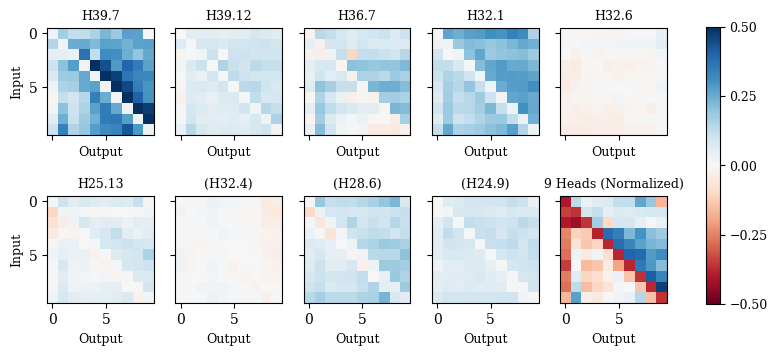

In [44]:
offset = 1

heads_display_order = [(39,7), (39,12), (36,7), (32,1), (32,6), (25,13)] + [(32,4), (28,6), (24,9)]
matrices = [head_diffs_offset[offset][(layer, idx)].cpu().numpy() for layer, idx in heads_display_order] + [aggregated_diff[offset].cpu().numpy() * 0.6]
titles = [f"H{l}.{h}" for l, h in heads_display_order[:6]] + [f"(H{l}.{h})" for l, h in heads_display_order[6:]] + ["9 Heads (Normalized)"]

# Create figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each matrix
for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    im = ax.imshow(matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Output", fontsize=9)
    if i % 5 == 0:
        ax.set_ylabel("Input", fontsize=9)
    else:
        ax.set_yticks([0, 5])

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, ticks=[-0.5, -0.25, 0, 0.25, 0.5])
cbar.ax.tick_params(labelsize=9)  # set tick label font size to 12

# plt.savefig("figures/fv_offset{}.pdf".format(offset), dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

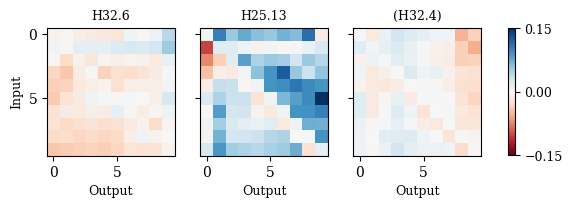

In [45]:
offset = 1
heads_display_order = [(32,6), (25,13)] + [(32,4)]
matrices = [head_diffs_offset[offset][(layer, idx)].cpu().numpy() for layer, idx in heads_display_order]
titles = [f"H{l}.{h}" for l, h in heads_display_order[:2]] + [f"(H{l}.{h})" for l, h in heads_display_order[2:]]

# Create figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(7, 3), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each matrix
for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    im = ax.imshow(matrix, cmap="RdBu", vmin=-0.15, vmax=0.15)
    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Output", fontsize=9)
    if i % 5 == 0:
        ax.set_ylabel("Input", fontsize=9)
    else:
        ax.set_yticks([0, 5])

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.55, ticks=[-0.15, 0, 0.15])
cbar.ax.tick_params(labelsize=9)  # set tick label font size to 12

# plt.tight_layout()

plt.savefig("figures/fv_scale.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

### Comparing different offsets

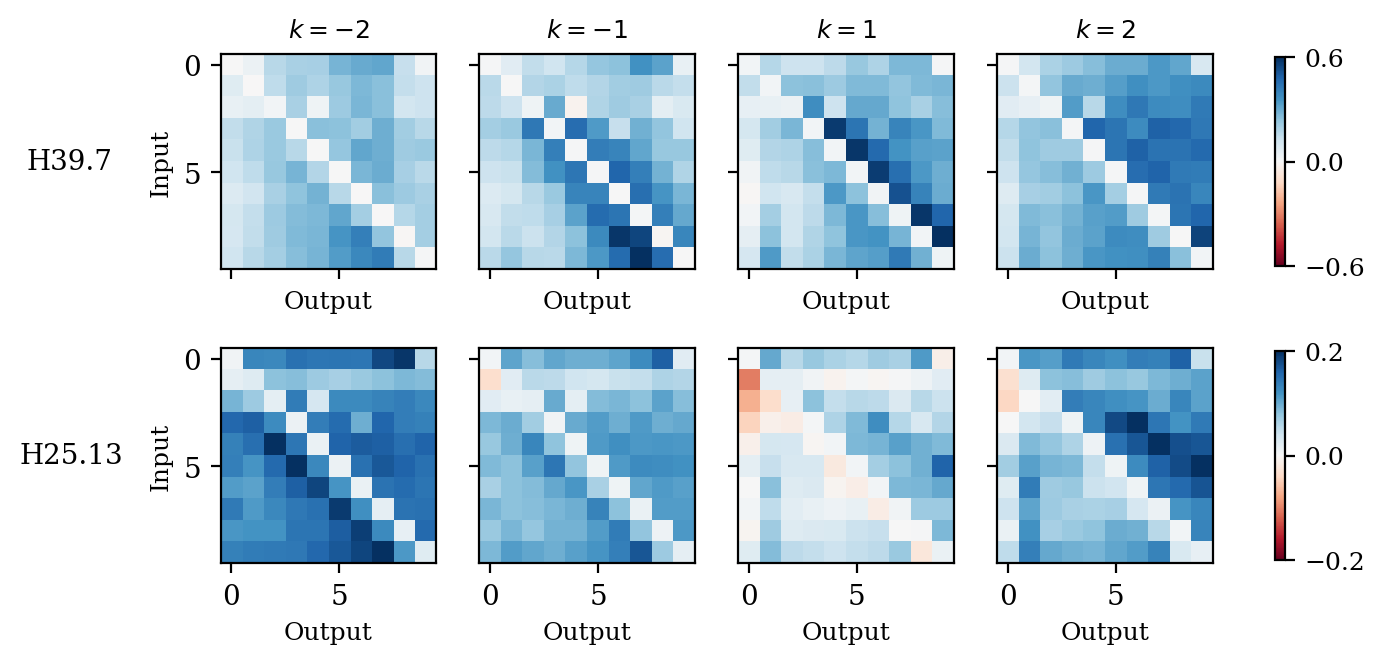

In [47]:
# Create figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 4, figsize=(8, 3.5), sharex=True, sharey=True, dpi=200)

# Plot each matrix
offsets = [-2, -1, 1, 2]
for i, (ax, offset) in enumerate(zip(axes[0], offsets)):
    im = ax.imshow(head_diffs_offset[offset][(39, 7)].cpu().numpy(), cmap="RdBu", vmin=-0.6, vmax=0.6)
    ax.set_title(r"$k={}$".format(offset), fontsize=9)
    ax.set_xlabel("Output", fontsize=9)
    if i == 0:
        ax.set_ylabel("Input", fontsize=9)
    else:
        ax.set_yticks([0, 5])

cbar = fig.colorbar(im, ax=axes[0].ravel().tolist(), shrink=0.85, ticks=[-0.6, 0, 0.6])
cbar.ax.tick_params(labelsize=9)  
axes[0, 0].text(-0.5, 0.5, "H39.7", transform=axes[0, 0].transAxes,
               va='center', ha='right', fontsize=10)

for i, (ax, offset) in enumerate(zip(axes[1], offsets)):
    im = ax.imshow(head_diffs_offset[offset][(25, 13)].cpu().numpy(), cmap="RdBu", vmin=-0.2, vmax=0.2)
    ax.set_xlabel("Output", fontsize=9)
    if i == 0:
        ax.set_ylabel("Input", fontsize=9)
    else:
        ax.set_yticks([0, 5])

# Add colorbar
cbar = fig.colorbar(im, ax=axes[1].ravel().tolist(), shrink=0.85, ticks=[-0.2, 0, 0.2])
cbar.ax.tick_params(labelsize=9) 
# plt.tight_layout()
axes[1, 0].text(-0.45, 0.5, "H25.13", transform=axes[1, 0].transAxes,
               va='center', ha='right', fontsize=10)

plt.savefig("figures/fv_different_offset.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

### Bonus: Effect of FVs in Standard Addition

In [8]:
offset = 1
fvs_standard = {}

data = load_data(offset)
batch_size = 4
for st in trange(0, len(data), batch_size):
    ed = st + batch_size
    batch = data[st: ed]

    for head_layer, head_idx in heads:
        t.cuda.empty_cache()
        _, _, _, _, normal_cache, contrast_cache, normal_logits, contrast_logits = prepare_data_for_fwd(model, batch)
        
        head_out = normal_cache[utils.get_act_name("z", head_layer)][:, -1, head_idx, :]

        if (head_layer, head_idx) in fvs_standard:
            fvs_standard[(head_layer, head_idx)].append(head_out)
        else:
            fvs_standard[(head_layer, head_idx)] = [head_out]
        del contrast_cache
        del normal_cache
    
for head_layer, head_idx in heads:
    tensors = fvs_standard[(head_layer, head_idx)]
    fvs_standard[(head_layer, head_idx)] = t.cat(tensors, dim=0).mean(dim=0)

100%|██████████| 25/25 [02:16<00:00,  5.47s/it]


In [12]:
head_diffs_standard = {}
for head_layer, head_idx in heads:
    fwd_hooks = [(utils.get_act_name("z", head_layer), partial(apply_fv_hook, head_idx=head_idx, fvs=fvs_standard))]
    fv_applied_logits = model.run_with_hooks(prompts, fwd_hooks=fwd_hooks)

    fv_applied_logits = fv_applied_logits[:, -1, digit_token_ids] # batch_size x [0-9]

    diff = fv_applied_logits - digit_logits
    head_diffs_standard[(head_layer, head_idx)] = diff

In [13]:
# aggregated effect of 9 heads
fwd_hooks = [(utils.get_act_name("z", head_layer), partial(apply_fv_hook, head_idx=head_idx, fvs=fvs_standard)) for head_layer, head_idx in heads]
fv_applied_logits = model.run_with_hooks(prompts, fwd_hooks=fwd_hooks)

fv_applied_logits = fv_applied_logits[:, -1, digit_token_ids] # batch_size x [0-9]

diff = fv_applied_logits - digit_logits
normalized_diff_standard = diff - diff.mean(0).mean(0)


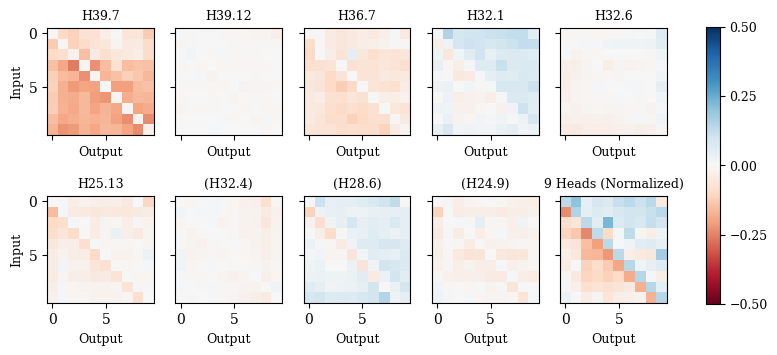

In [17]:
offset = 1

heads_display_order = [(39,7), (39,12), (36,7), (32,1), (32,6), (25,13)] + [(32,4), (28,6), (24,9)]
matrices = [head_diffs_standard[(layer, idx)].cpu().numpy() for layer, idx in heads_display_order] + [normalized_diff_standard.cpu().numpy() * 0.6]
titles = [f"H{l}.{h}" for l, h in heads_display_order[:6]] + [f"(H{l}.{h})" for l, h in heads_display_order[6:]] + ["9 Heads (Normalized)"]

# Create figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each matrix
for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    im = ax.imshow(matrix, cmap="RdBu", vmin=-0.5, vmax=0.5)
    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Output", fontsize=9)
    if i % 5 == 0:
        ax.set_ylabel("Input", fontsize=9)
    else:
        ax.set_yticks([0, 5])

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, ticks=[-0.5, -0.25, 0, 0.25, 0.5])
cbar.ax.tick_params(labelsize=9)  # set tick label font size to 12

plt.savefig("figures/fv_normal.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()